In [529]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata

In [530]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures):
    ratings = {}

    # Iterate over teams in the results data
    teams = set(df_results['home_team']).union(set(df_results['away_team'])).union(set(df_fixtures['home_team'])).union(set(df_fixtures['away_team']))
    for team in teams:
        # Initialize ratings for each team
        ratings[team] = {
            'brH': 0.0,
            'brA': 0.0,
            'continuous_overunderperformances': 0
        }
    #print('Teams:', teams, end='\n\n')
    return ratings

In [531]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma):

    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        if index > 2000:
            #add current game to training data
            training_games.append({
                "brH_x": ratings[row["home_team"]]["brH"],
                "brA_x": ratings[row["home_team"]]["brA"],
                "prH_x": calculate_provisional_ratings(ratings, row["home_team"])[0],
                "prA_x": calculate_provisional_ratings(ratings, row["home_team"])[1],
                "brH_y": ratings[row["away_team"]]["brH"],
                "brA_y": ratings[row["away_team"]]["brA"],
                "prH_y": calculate_provisional_ratings(ratings, row["away_team"])[0],
                "prA_y": calculate_provisional_ratings(ratings, row["away_team"])[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["home_team"])[0]) - (calculate_provisional_ratings(ratings, row["away_team"])[1]),
                "home_goals": row["home_goals"],
                "away_goals": row["away_goals"],
                "result": row["result"]
            })


        if np.isnan(ratings[row['home_team']]['brH']):
            print("error")
            break

        #print("Game Nr:", index)

        #time.sleep(0.001)

        ratings = update_ratings_single_game(row['home_team'], row['away_team'], row['home_goals'], row['away_goals'], ratings, learning_rate_lambda, learning_rate_gamma)

        games_with_rating.append({
            "team": row["home_team"],
            "home_rating": ratings[row["home_team"]]["brH"],
            "away_rating": ratings[row["home_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["home_team"]]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["away_team"],
            "home_rating": ratings[row["away_team"]]["brH"],
            "away_rating": ratings[row["away_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["away_team"]]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [532]:
# Function to update ratings based on results data
def update_ratings_single_game(home_team, away_team, home_goals, away_goals, ratings, learning_rate_lambda, learning_rate_gamma):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79

    #print(home_team, "-", away_team, home_goals, ":", away_goals)


    observed_goal_difference = home_goals - away_goals
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[home_team]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[home_team]['brH']) / 3
    expected_goal_x = np.sign(ratings[home_team]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[away_team]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[away_team]['brA']) / 3
    expected_goal_y = np.sign(ratings[away_team]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[home_team]['brH']
    previous_away_rating_x = ratings[home_team]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[home_team]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[home_team]['brA'] = previous_away_rating_x + (ratings[home_team]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[home_team]['brH'])
    #print("New brA x:", ratings[home_team]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[away_team]['brH']
    previous_away_rating_y = ratings[away_team]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[away_team]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[away_team]['brH'] = previous_home_rating_y + (ratings[away_team]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[away_team]['brH'])
    #print("New brA y:", ratings[away_team]['brA'])

    #print("Old overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[away_team]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = max(1, ratings[home_team]['continuous_overunderperformances'] + 1)
        ratings[away_team]['continuous_overunderperformances'] = min(-1, ratings[away_team]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = min(-1, ratings[home_team]['continuous_overunderperformances'] - 1)
        ratings[away_team]['continuous_overunderperformances'] = max(1, ratings[away_team]['continuous_overunderperformances'] + 1)
    else:
        ratings[home_team]['continuous_overunderperformances'] = 0
        ratings[away_team]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[away_team]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [553]:
def calculate_provisional_ratings(ratings, team):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    form_threshold_phi = 1

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    rating_impact_mu = 0.01

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    diminishing_factor_delta = 2.5

    brH = ratings[team]['brH']  # Background rating home
    brA = ratings[team]['brA']  # Background rating away
    prH = brH
    prA = brA

    return prH, prA

    if abs(ratings[team]['continuous_overunderperformances']) < 2:
        return prH, prA

    # Calculate performance factor for home team x
    a = abs(ratings[team]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    if (ratings[team]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home

    #return prH, prA

In [554]:
def calculate_probabilities(features):
    # Load the model and label encoder
    model = joblib.load('../Models/model.pkl')

    # Now you can predict probabilities for a new game:
    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [555]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(home_team, away_team, ratings):

    # Calculate home team rating
    home_rating_x = ratings[home_team]['brH']
    if (abs(ratings[home_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, home_team)
        home_rating_x = provisional_ratings_x[0]

    # Calculate away team rating
    away_rating_y = ratings[away_team]['brA']
    if (abs(ratings[away_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, away_team)
        away_rating_y = provisional_ratings_y[1]

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [556]:
def predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma):
    all_rps = []
    league_table = pd.DataFrame(columns=['team', 'games_played', 'points'])

    for index, row in df_fixtures.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        rating_difference = calculate_rating_difference(home_team, away_team, ratings)
        """
        prH_x = calculate_provisional_ratings(ratings, home_team)[0]
        prA_x = calculate_provisional_ratings(ratings, away_team)[1]
        prH_y = calculate_provisional_ratings(ratings, home_team)[0]
        prA_y = calculate_provisional_ratings(ratings, away_team)[1]
        """

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features)

        home_goals = int(row['home_goals'])
        away_goals = int(row['away_goals'])

        """
        print(f"{home_team} - {away_team} {home_goals}:{away_goals}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}")
        """

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["result"] == "H":
            outcome = [1, 0, 0]
        elif row["result"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

         # Compute expected points for both teams
        home_points = home_win_prob * 3 + draw_prob
        away_points = away_win_prob * 3 + draw_prob

        # Update league table
        league_table = update_league_table(league_table, home_team, away_team, home_win_prob, draw_prob, away_win_prob)

        ratings = update_ratings_single_game(home_team, away_team, row['home_goals'], row['away_goals'], ratings, learning_rate_lambda, learning_rate_gamma)

    print("Average RPS Score:", np.mean(all_rps), end='\n\n')

    league_table = league_table.sort_values(['points', 'games_played'], ascending=False)
    league_table = league_table.reset_index(drop=True)


    return all_rps, league_table


In [557]:
def update_league_table(league_table, home_team, away_team, home_win_prob, draw_prob, away_win_prob):
    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if home_team in league_table['team'].values:
        league_table.loc[league_table['team'] == home_team, 'games_played'] += 1
        league_table.loc[league_table['team'] == home_team, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [home_team], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if away_team in league_table['team'].values:
        league_table.loc[league_table['team'] == away_team, 'games_played'] += 1
        league_table.loc[league_table['team'] == away_team, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [away_team], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [558]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [559]:

def train_model(df_train):

    # Create Logistic Regression model
    #model = LogisticRegression(solver="saga", penalty="l2")  # 'ovr' stands for One-Vs-Rest
    model = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=23, max_iter=1000)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['result']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.00001, random_state=42)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model


Average RPS Score: 0.18704255974707587



''

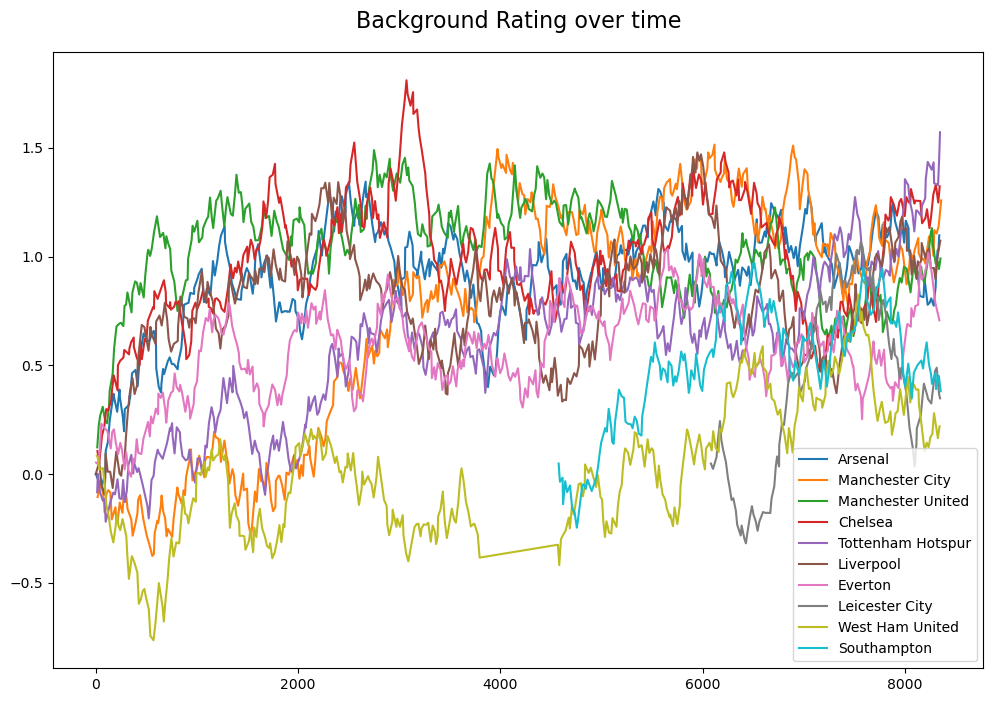

In [560]:

# Load the results data file for seasons 2006-07 to 2016-17
df_results = pd.read_csv('../data/results.csv')

# Load the fixtures data file for the season 2017-18
df_fixtures = pd.read_csv('../data/results201718.csv')

# Initialize ratings based on the results data
ratings = initialize_ratings(df_results, df_fixtures)

learning_rate_lambda = 0.06
learning_rate_gamma = 0.95

# Update ratings based on the results data
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)
#model.C_


plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Manchester City", "Manchester United", "Chelsea", "Tottenham Hotspur", "Liverpool", "Everton", "Leicester City", "West Ham United", "Southampton"]
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time.png", dpi=300)

df_train = pd.DataFrame(training_games)

df_train.to_csv("../data/train.csv", index=False)

model = train_model(df_train)

# Predict the probabilities of home win, draw and away win for the fixtures data
all_rps, league_table = predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)

;

                        team games_played     points
1            Manchester City           38  78.462067
2          Tottenham Hotspur           38  75.836560
3                    Chelsea           38  73.298387
4                  Liverpool           38  73.172539
5          Manchester United           38  72.910246
6                    Arsenal           38  69.106090
7             Leicester City           38  52.612737
8                    Everton           38  51.320475
9                    Burnley           38  49.456744
10               Southampton           38  45.436711
11           AFC Bournemouth           38  44.379424
12          Newcastle United           38  43.233480
13           West Ham United           38  42.926900
14            Crystal Palace           38  41.606931
15              Swansea City           38  40.992753
16      West Bromwich Albion           38  40.276542
17  Brighton and Hove Albion           38  39.304951
18                Stoke City           38  38.

''

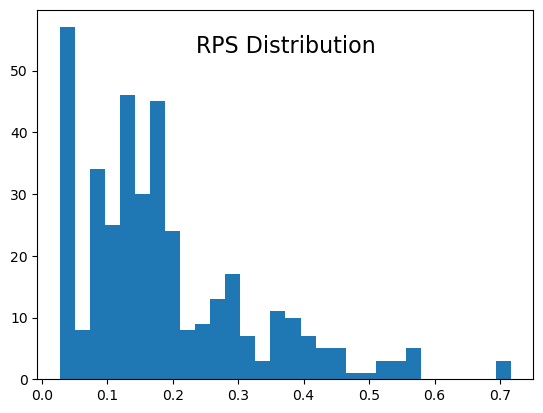

In [541]:

plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=30)
plt.savefig("../images/rps_distribution.png", dpi=300)


league_table.index = league_table.index + 1
print(league_table)
league_table.index = league_table.index - 1

"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

  0%|          | 1/361 [00:01<11:23,  1.90s/it]

Average RPS Score: 0.19389629887093612



  1%|          | 2/361 [00:03<11:01,  1.84s/it]

Average RPS Score: 0.1928274368525715



  1%|          | 3/361 [00:05<11:00,  1.84s/it]

Average RPS Score: 0.19292512785546176



  1%|          | 4/361 [00:07<10:53,  1.83s/it]

Average RPS Score: 0.1926447092530114



  1%|▏         | 5/361 [00:09<11:03,  1.86s/it]

Average RPS Score: 0.19317581928899405



  2%|▏         | 6/361 [00:11<10:48,  1.83s/it]

Average RPS Score: 0.19270494242075906



  2%|▏         | 7/361 [00:12<10:32,  1.79s/it]

Average RPS Score: 0.19279383915548315



  2%|▏         | 8/361 [00:14<10:31,  1.79s/it]

Average RPS Score: 0.1927291526310639



  2%|▏         | 9/361 [00:16<10:25,  1.78s/it]

Average RPS Score: 0.1923836532516324



  3%|▎         | 10/361 [00:17<10:13,  1.75s/it]

Average RPS Score: 0.1919763955838806



  3%|▎         | 11/361 [00:19<10:04,  1.73s/it]

Average RPS Score: 0.19264685912642834



  3%|▎         | 12/361 [00:21<10:07,  1.74s/it]

Average RPS Score: 0.19115179830571244



  4%|▎         | 13/361 [00:23<10:03,  1.73s/it]

Average RPS Score: 0.19086195540513826



  4%|▍         | 14/361 [00:24<10:01,  1.73s/it]

Average RPS Score: 0.19213616138253356



  4%|▍         | 15/361 [00:26<09:48,  1.70s/it]

Average RPS Score: 0.19053608266462665



  4%|▍         | 16/361 [00:28<09:50,  1.71s/it]

Average RPS Score: 0.190993625624455



  5%|▍         | 17/361 [00:29<09:50,  1.72s/it]

Average RPS Score: 0.19052240779637342



  5%|▍         | 18/361 [00:31<09:38,  1.69s/it]

Average RPS Score: 0.1922922860456407



  5%|▌         | 19/361 [00:33<09:32,  1.67s/it]

Average RPS Score: 0.191095398410177



  6%|▌         | 20/361 [00:34<09:34,  1.69s/it]

Average RPS Score: 0.19404231964966423



  6%|▌         | 21/361 [00:36<09:26,  1.67s/it]

Average RPS Score: 0.1926824264086609



  6%|▌         | 22/361 [00:38<09:27,  1.68s/it]

Average RPS Score: 0.19242423423557098



  6%|▋         | 23/361 [00:40<09:34,  1.70s/it]

Average RPS Score: 0.19246360463391887



  7%|▋         | 24/361 [00:41<09:29,  1.69s/it]

Average RPS Score: 0.19250941014348263



  7%|▋         | 25/361 [00:43<09:22,  1.67s/it]

Average RPS Score: 0.1926115265700258



  7%|▋         | 26/361 [00:45<09:27,  1.69s/it]

Average RPS Score: 0.1927110700998029



  7%|▋         | 27/361 [00:46<09:28,  1.70s/it]

Average RPS Score: 0.1926800283235145



  8%|▊         | 28/361 [00:48<09:21,  1.69s/it]

Average RPS Score: 0.19219978998469123



  8%|▊         | 29/361 [00:50<09:11,  1.66s/it]

Average RPS Score: 0.19210963916138732



  8%|▊         | 30/361 [00:51<09:07,  1.66s/it]

Average RPS Score: 0.19175543154692895



  9%|▊         | 31/361 [00:53<08:59,  1.63s/it]

Average RPS Score: 0.19091280272366723



  9%|▉         | 32/361 [00:54<09:02,  1.65s/it]

Average RPS Score: 0.19035821993083396



  9%|▉         | 33/361 [00:56<09:00,  1.65s/it]

Average RPS Score: 0.19033330825947029



  9%|▉         | 34/361 [00:58<09:05,  1.67s/it]

Average RPS Score: 0.1907093832917705



 10%|▉         | 35/361 [01:00<09:07,  1.68s/it]

Average RPS Score: 0.19060050200531817



 10%|▉         | 36/361 [01:01<08:58,  1.66s/it]

Average RPS Score: 0.19188078700312527



 10%|█         | 37/361 [01:03<08:54,  1.65s/it]

Average RPS Score: 0.19066960219896645



 11%|█         | 38/361 [01:04<08:59,  1.67s/it]

Average RPS Score: 0.19054703970520473



 11%|█         | 39/361 [01:06<08:57,  1.67s/it]

Average RPS Score: 0.19313184907974087



 11%|█         | 40/361 [01:08<08:55,  1.67s/it]

Average RPS Score: 0.19252698886500452



 11%|█▏        | 41/361 [01:09<08:51,  1.66s/it]

Average RPS Score: 0.1922654597835271



 12%|█▏        | 42/361 [01:11<08:46,  1.65s/it]

Average RPS Score: 0.1923618934258435



 12%|█▏        | 43/361 [01:13<08:42,  1.64s/it]

Average RPS Score: 0.1924257863346137



 12%|█▏        | 44/361 [01:14<08:53,  1.68s/it]

Average RPS Score: 0.19266626117904628



 12%|█▏        | 45/361 [01:16<08:54,  1.69s/it]

Average RPS Score: 0.1925330403396364



 13%|█▎        | 46/361 [01:18<08:58,  1.71s/it]

Average RPS Score: 0.1924189177750787



 13%|█▎        | 47/361 [01:20<08:56,  1.71s/it]

Average RPS Score: 0.1917999456569459



 13%|█▎        | 48/361 [01:21<08:56,  1.71s/it]

Average RPS Score: 0.1918688734893843



 14%|█▎        | 49/361 [01:23<09:11,  1.77s/it]

Average RPS Score: 0.19149745231845341



 14%|█▍        | 50/361 [01:25<09:07,  1.76s/it]

Average RPS Score: 0.19078611437536722



 14%|█▍        | 51/361 [01:27<09:08,  1.77s/it]

Average RPS Score: 0.19010950762850437



 14%|█▍        | 52/361 [01:28<08:58,  1.74s/it]

Average RPS Score: 0.1904906356978775



 15%|█▍        | 53/361 [01:30<08:42,  1.70s/it]

Average RPS Score: 0.19044226682798102



 15%|█▍        | 54/361 [01:32<08:22,  1.64s/it]

Average RPS Score: 0.19030021252478874



 15%|█▌        | 55/361 [01:33<08:10,  1.60s/it]

Average RPS Score: 0.19061821155983388



 16%|█▌        | 56/361 [01:35<08:16,  1.63s/it]

Average RPS Score: 0.19031407718157073



 16%|█▌        | 57/361 [01:36<08:11,  1.62s/it]

Average RPS Score: 0.19170943431292783



 16%|█▌        | 58/361 [01:38<08:08,  1.61s/it]

Average RPS Score: 0.19284856168717124



 16%|█▋        | 59/361 [01:40<08:17,  1.65s/it]

Average RPS Score: 0.19235795310667092



 17%|█▋        | 60/361 [01:41<08:26,  1.68s/it]

Average RPS Score: 0.19228759298919434



 17%|█▋        | 61/361 [01:43<08:24,  1.68s/it]

Average RPS Score: 0.19235513648051872



 17%|█▋        | 62/361 [01:45<08:22,  1.68s/it]

Average RPS Score: 0.19262287051949234



 17%|█▋        | 63/361 [01:46<08:16,  1.67s/it]

Average RPS Score: 0.19261386880302547



 18%|█▊        | 64/361 [01:48<08:14,  1.67s/it]

Average RPS Score: 0.1925937114603611



 18%|█▊        | 65/361 [01:50<08:08,  1.65s/it]

Average RPS Score: 0.1919306280224039



 18%|█▊        | 66/361 [01:51<08:05,  1.65s/it]

Average RPS Score: 0.19172697268155317



 19%|█▊        | 67/361 [01:53<08:01,  1.64s/it]

Average RPS Score: 0.19219841436166768



 19%|█▉        | 68/361 [01:55<08:07,  1.66s/it]

Average RPS Score: 0.1919419359441332



 19%|█▉        | 69/361 [01:56<08:04,  1.66s/it]

Average RPS Score: 0.1904568006090702



 19%|█▉        | 70/361 [01:58<07:55,  1.63s/it]

Average RPS Score: 0.1909861072877853



 20%|█▉        | 71/361 [02:00<08:03,  1.67s/it]

Average RPS Score: 0.19022782439241132



 20%|█▉        | 72/361 [02:01<07:57,  1.65s/it]

Average RPS Score: 0.1901521447032041



 20%|██        | 73/361 [02:03<07:47,  1.62s/it]

Average RPS Score: 0.1904653072107433



 20%|██        | 74/361 [02:04<07:47,  1.63s/it]

Average RPS Score: 0.1902198776856566



 21%|██        | 75/361 [02:06<07:43,  1.62s/it]

Average RPS Score: 0.19167098318661924



 21%|██        | 76/361 [02:08<07:53,  1.66s/it]

Average RPS Score: 0.19151804905693448



 21%|██▏       | 77/361 [02:10<08:09,  1.72s/it]

Average RPS Score: 0.19243039095791747



 22%|██▏       | 78/361 [02:11<08:12,  1.74s/it]

Average RPS Score: 0.19228225862983997



 22%|██▏       | 79/361 [02:13<08:09,  1.74s/it]

Average RPS Score: 0.1924140541034195



 22%|██▏       | 80/361 [02:15<08:05,  1.73s/it]

Average RPS Score: 0.1921612678044782



 22%|██▏       | 81/361 [02:17<08:07,  1.74s/it]

Average RPS Score: 0.19269038353111523



 23%|██▎       | 82/361 [02:18<08:01,  1.72s/it]

Average RPS Score: 0.19252174696473268



 23%|██▎       | 83/361 [02:20<07:57,  1.72s/it]

Average RPS Score: 0.19243693969911765



 23%|██▎       | 84/361 [02:22<07:50,  1.70s/it]

Average RPS Score: 0.1918157050152705



 24%|██▎       | 85/361 [02:23<07:45,  1.69s/it]

Average RPS Score: 0.19166345025118606



 24%|██▍       | 86/361 [02:25<07:43,  1.68s/it]

Average RPS Score: 0.19181233484663648



 24%|██▍       | 87/361 [02:27<07:41,  1.68s/it]

Average RPS Score: 0.19147294005263957



 24%|██▍       | 88/361 [02:28<07:35,  1.67s/it]

Average RPS Score: 0.19135201667004764



 25%|██▍       | 89/361 [02:30<07:30,  1.66s/it]

Average RPS Score: 0.1910704390706609



 25%|██▍       | 90/361 [02:32<07:23,  1.64s/it]

Average RPS Score: 0.1915421106206861



 25%|██▌       | 91/361 [02:33<07:18,  1.62s/it]

Average RPS Score: 0.19016561550482572



 25%|██▌       | 92/361 [02:35<07:18,  1.63s/it]

Average RPS Score: 0.19000629780778647



 26%|██▌       | 93/361 [02:36<07:18,  1.64s/it]

Average RPS Score: 0.19180263860069371



 26%|██▌       | 94/361 [02:38<07:28,  1.68s/it]

Average RPS Score: 0.19034677411747666



 26%|██▋       | 95/361 [02:40<07:24,  1.67s/it]

Average RPS Score: 0.191626975358195



 27%|██▋       | 96/361 [02:42<07:21,  1.67s/it]

Average RPS Score: 0.19245344776676504



 27%|██▋       | 97/361 [02:43<07:22,  1.68s/it]

Average RPS Score: 0.19236301321111243



 27%|██▋       | 98/361 [02:45<07:30,  1.71s/it]

Average RPS Score: 0.19218233438127028



 27%|██▋       | 99/361 [02:47<07:25,  1.70s/it]

Average RPS Score: 0.19245137199329254



 28%|██▊       | 100/361 [02:48<07:25,  1.71s/it]

Average RPS Score: 0.19261717905678907



 28%|██▊       | 101/361 [02:50<07:19,  1.69s/it]

Average RPS Score: 0.19243973918249585



 28%|██▊       | 102/361 [02:52<07:15,  1.68s/it]

Average RPS Score: 0.19200700478298088



 29%|██▊       | 103/361 [02:53<07:11,  1.67s/it]

Average RPS Score: 0.1919332239156002



 29%|██▉       | 104/361 [02:55<07:08,  1.67s/it]

Average RPS Score: 0.19119768832572248



 29%|██▉       | 105/361 [02:57<07:07,  1.67s/it]

Average RPS Score: 0.19178217307730663



 29%|██▉       | 106/361 [02:58<07:01,  1.65s/it]

Average RPS Score: 0.19165176254296656



 30%|██▉       | 107/361 [03:00<07:02,  1.66s/it]

Average RPS Score: 0.1914240392075017



 30%|██▉       | 108/361 [03:02<07:05,  1.68s/it]

Average RPS Score: 0.19102547706100728



 30%|███       | 109/361 [03:03<06:59,  1.67s/it]

Average RPS Score: 0.1913927683095453



 30%|███       | 110/361 [03:05<07:01,  1.68s/it]

Average RPS Score: 0.1915333955661627



 31%|███       | 111/361 [03:07<07:04,  1.70s/it]

Average RPS Score: 0.19029788793672478



 31%|███       | 112/361 [03:09<06:57,  1.68s/it]

Average RPS Score: 0.19111238557247315



 31%|███▏      | 113/361 [03:10<06:51,  1.66s/it]

Average RPS Score: 0.19154004782936251



 32%|███▏      | 114/361 [03:12<06:52,  1.67s/it]

Average RPS Score: 0.1912883972676741



 32%|███▏      | 115/361 [03:13<06:47,  1.66s/it]

Average RPS Score: 0.19197194759079791



 32%|███▏      | 116/361 [03:15<06:49,  1.67s/it]

Average RPS Score: 0.19210354872369806



 32%|███▏      | 117/361 [03:17<07:00,  1.72s/it]

Average RPS Score: 0.19225911771353124



 33%|███▎      | 118/361 [03:19<06:50,  1.69s/it]

Average RPS Score: 0.19218094969508667



 33%|███▎      | 119/361 [03:20<06:45,  1.68s/it]

Average RPS Score: 0.19270573187260903



 33%|███▎      | 120/361 [03:22<06:42,  1.67s/it]

Average RPS Score: 0.19242153647592802



 34%|███▎      | 121/361 [03:24<06:37,  1.66s/it]

Average RPS Score: 0.19209901320888156



 34%|███▍      | 122/361 [03:25<06:37,  1.66s/it]

Average RPS Score: 0.19170786413701868



 34%|███▍      | 123/361 [03:27<06:37,  1.67s/it]

Average RPS Score: 0.19181228539894085



 34%|███▍      | 124/361 [03:29<06:33,  1.66s/it]

Average RPS Score: 0.19155053948594536



 35%|███▍      | 125/361 [03:30<06:27,  1.64s/it]

Average RPS Score: 0.19126252260949295



 35%|███▍      | 126/361 [03:32<06:23,  1.63s/it]

Average RPS Score: 0.1913610261453378



 35%|███▌      | 127/361 [03:33<06:20,  1.63s/it]

Average RPS Score: 0.19130683671412965



 35%|███▌      | 128/361 [03:35<06:15,  1.61s/it]

Average RPS Score: 0.19087613113605384



 36%|███▌      | 129/361 [03:36<06:09,  1.59s/it]

Average RPS Score: 0.19080883781585947



 36%|███▌      | 130/361 [03:38<06:06,  1.59s/it]

Average RPS Score: 0.19109015570249924



 36%|███▋      | 131/361 [03:40<06:11,  1.62s/it]

Average RPS Score: 0.1910919679370496



 37%|███▋      | 132/361 [03:41<06:11,  1.62s/it]

Average RPS Score: 0.19103132278452326



 37%|███▋      | 133/361 [03:43<06:13,  1.64s/it]

Average RPS Score: 0.19098866953559415



 37%|███▋      | 134/361 [03:45<06:09,  1.63s/it]

Average RPS Score: 0.1916826347260909



 37%|███▋      | 135/361 [03:46<06:06,  1.62s/it]

Average RPS Score: 0.1916187661989485



 38%|███▊      | 136/361 [03:48<06:04,  1.62s/it]

Average RPS Score: 0.19184063654042016



 38%|███▊      | 137/361 [03:50<06:04,  1.63s/it]

Average RPS Score: 0.19214958828595705



 38%|███▊      | 138/361 [03:51<06:05,  1.64s/it]

Average RPS Score: 0.19247267975530888



 39%|███▊      | 139/361 [03:53<06:00,  1.63s/it]

Average RPS Score: 0.19230396274577394



 39%|███▉      | 140/361 [03:54<05:58,  1.62s/it]

Average RPS Score: 0.19183077354443695



 39%|███▉      | 141/361 [03:56<06:02,  1.65s/it]

Average RPS Score: 0.19164219982289796



 39%|███▉      | 142/361 [03:58<06:00,  1.65s/it]

Average RPS Score: 0.19186275069963724



 40%|███▉      | 143/361 [03:59<05:55,  1.63s/it]

Average RPS Score: 0.19117460774169098



 40%|███▉      | 144/361 [04:01<05:56,  1.64s/it]

Average RPS Score: 0.1913645733531816



 40%|████      | 145/361 [04:03<05:53,  1.64s/it]

Average RPS Score: 0.1914364743266709



 40%|████      | 146/361 [04:04<05:53,  1.64s/it]

Average RPS Score: 0.19055209800437423



 41%|████      | 147/361 [04:06<05:52,  1.65s/it]

Average RPS Score: 0.19091434698970666



 41%|████      | 148/361 [04:08<05:52,  1.65s/it]

Average RPS Score: 0.19089356231457208



 41%|████▏     | 149/361 [04:09<05:50,  1.65s/it]

Average RPS Score: 0.19094009098831655



 42%|████▏     | 150/361 [04:11<05:47,  1.65s/it]

Average RPS Score: 0.19104087329542255



 42%|████▏     | 151/361 [04:13<05:43,  1.64s/it]

Average RPS Score: 0.19089073827601744



 42%|████▏     | 152/361 [04:14<05:43,  1.64s/it]

Average RPS Score: 0.19100056499295553



 42%|████▏     | 153/361 [04:16<05:43,  1.65s/it]

Average RPS Score: 0.1913512848957725



 43%|████▎     | 154/361 [04:18<05:41,  1.65s/it]

Average RPS Score: 0.19162256869439803



 43%|████▎     | 155/361 [04:19<05:43,  1.67s/it]

Average RPS Score: 0.19173072360896698



 43%|████▎     | 156/361 [04:21<05:58,  1.75s/it]

Average RPS Score: 0.1922174277595103



 43%|████▎     | 157/361 [04:23<05:53,  1.73s/it]

Average RPS Score: 0.19251727116759562



 44%|████▍     | 158/361 [04:24<05:46,  1.71s/it]

Average RPS Score: 0.192242416442773



 44%|████▍     | 159/361 [04:26<05:43,  1.70s/it]

Average RPS Score: 0.19188660740599414



 44%|████▍     | 160/361 [04:28<05:38,  1.69s/it]

Average RPS Score: 0.191691633614587



 45%|████▍     | 161/361 [04:29<05:30,  1.65s/it]

Average RPS Score: 0.19132591461040496



 45%|████▍     | 162/361 [04:31<05:28,  1.65s/it]

Average RPS Score: 0.191319804651291



 45%|████▌     | 163/361 [04:33<05:23,  1.63s/it]

Average RPS Score: 0.1910774045450233



 45%|████▌     | 164/361 [04:34<05:18,  1.62s/it]

Average RPS Score: 0.19116214841599055



 46%|████▌     | 165/361 [04:36<05:25,  1.66s/it]

Average RPS Score: 0.19082667870889602



 46%|████▌     | 166/361 [04:38<05:23,  1.66s/it]

Average RPS Score: 0.19076032014810052



 46%|████▋     | 167/361 [04:39<05:21,  1.66s/it]

Average RPS Score: 0.19076187073543055



 47%|████▋     | 168/361 [04:41<05:21,  1.66s/it]

Average RPS Score: 0.19061226864524636



 47%|████▋     | 169/361 [04:43<05:23,  1.68s/it]

Average RPS Score: 0.19072520721436642



 47%|████▋     | 170/361 [04:44<05:19,  1.67s/it]

Average RPS Score: 0.19082200608465044



 47%|████▋     | 171/361 [04:46<05:17,  1.67s/it]

Average RPS Score: 0.19106722178858485



 48%|████▊     | 172/361 [04:48<05:15,  1.67s/it]

Average RPS Score: 0.1911319792803237



 48%|████▊     | 173/361 [04:49<05:14,  1.67s/it]

Average RPS Score: 0.19148677950450144



 48%|████▊     | 174/361 [04:51<05:17,  1.70s/it]

Average RPS Score: 0.19150486926652638



 48%|████▊     | 175/361 [04:53<05:15,  1.69s/it]

Average RPS Score: 0.19193301743309332



 49%|████▉     | 176/361 [04:54<05:11,  1.68s/it]

Average RPS Score: 0.19212336275179945



 49%|████▉     | 177/361 [04:56<05:09,  1.68s/it]

Average RPS Score: 0.19218749373716806



 49%|████▉     | 178/361 [04:58<05:06,  1.68s/it]

Average RPS Score: 0.19201456460808672



 50%|████▉     | 179/361 [05:00<05:13,  1.72s/it]

Average RPS Score: 0.19178393173259425



 50%|████▉     | 180/361 [05:02<05:19,  1.77s/it]

Average RPS Score: 0.1914836621296286



 50%|█████     | 181/361 [05:04<05:39,  1.89s/it]

Average RPS Score: 0.19134788070398606



 50%|█████     | 182/361 [05:06<05:56,  1.99s/it]

Average RPS Score: 0.19092594739848226



 51%|█████     | 183/361 [05:08<05:41,  1.92s/it]

Average RPS Score: 0.1907501748971297



 51%|█████     | 184/361 [05:09<05:26,  1.84s/it]

Average RPS Score: 0.19034743343435034



 51%|█████     | 185/361 [05:11<05:21,  1.83s/it]

Average RPS Score: 0.19071222884634612



 52%|█████▏    | 186/361 [05:13<05:12,  1.78s/it]

Average RPS Score: 0.19072319312980285



 52%|█████▏    | 187/361 [05:15<05:17,  1.83s/it]

Average RPS Score: 0.1906615525727547



 52%|█████▏    | 188/361 [05:16<05:12,  1.80s/it]

Average RPS Score: 0.1906985257729935



 52%|█████▏    | 189/361 [05:18<05:08,  1.79s/it]

Average RPS Score: 0.19093808867907006



 53%|█████▎    | 190/361 [05:20<05:24,  1.90s/it]

Average RPS Score: 0.19114364381204255



 53%|█████▎    | 191/361 [05:22<05:20,  1.88s/it]

Average RPS Score: 0.190818141292724



 53%|█████▎    | 192/361 [05:24<05:17,  1.88s/it]

Average RPS Score: 0.1913364771648385



 53%|█████▎    | 193/361 [05:26<05:13,  1.87s/it]

Average RPS Score: 0.19142974839950416



 54%|█████▎    | 194/361 [05:28<05:01,  1.81s/it]

Average RPS Score: 0.19189365472054487



 54%|█████▍    | 195/361 [05:29<04:53,  1.77s/it]

Average RPS Score: 0.19213721931130134



 54%|█████▍    | 196/361 [05:31<04:49,  1.76s/it]

Average RPS Score: 0.1920915981422787



 55%|█████▍    | 197/361 [05:33<04:43,  1.73s/it]

Average RPS Score: 0.19196265905263368



 55%|█████▍    | 198/361 [05:34<04:38,  1.71s/it]

Average RPS Score: 0.19169740402400987



 55%|█████▌    | 199/361 [05:36<04:38,  1.72s/it]

Average RPS Score: 0.19079720344341428



 55%|█████▌    | 200/361 [05:38<04:33,  1.70s/it]

Average RPS Score: 0.1909239887456056



 56%|█████▌    | 201/361 [05:39<04:28,  1.68s/it]

Average RPS Score: 0.19078763848035366



 56%|█████▌    | 202/361 [05:41<04:27,  1.68s/it]

Average RPS Score: 0.19090318085689043



 56%|█████▌    | 203/361 [05:43<04:27,  1.69s/it]

Average RPS Score: 0.19065681477810129



 57%|█████▋    | 204/361 [05:44<04:25,  1.69s/it]

Average RPS Score: 0.19059219416945333



 57%|█████▋    | 205/361 [05:46<04:28,  1.72s/it]

Average RPS Score: 0.19057629263215792



 57%|█████▋    | 206/361 [05:48<04:23,  1.70s/it]

Average RPS Score: 0.19080559598989938



 57%|█████▋    | 207/361 [05:50<04:21,  1.70s/it]

Average RPS Score: 0.19087188881680264



 58%|█████▊    | 208/361 [05:51<04:20,  1.70s/it]

Average RPS Score: 0.19102755220339895



 58%|█████▊    | 209/361 [05:53<04:20,  1.71s/it]

Average RPS Score: 0.19113866085131917



 58%|█████▊    | 210/361 [05:55<04:17,  1.71s/it]

Average RPS Score: 0.19072104289936653



 58%|█████▊    | 211/361 [05:56<04:18,  1.72s/it]

Average RPS Score: 0.19112169925444508



 59%|█████▊    | 212/361 [05:58<04:13,  1.70s/it]

Average RPS Score: 0.19141022681547498



 59%|█████▉    | 213/361 [06:00<04:07,  1.67s/it]

Average RPS Score: 0.1918430658293464



 59%|█████▉    | 214/361 [06:01<04:07,  1.68s/it]

Average RPS Score: 0.19198637437276603



 60%|█████▉    | 215/361 [06:03<04:06,  1.69s/it]

Average RPS Score: 0.19174563538400094



 60%|█████▉    | 216/361 [06:05<04:04,  1.69s/it]

Average RPS Score: 0.19189899157936685



 60%|██████    | 217/361 [06:07<04:05,  1.70s/it]

Average RPS Score: 0.19152935484149755



 60%|██████    | 218/361 [06:08<04:01,  1.69s/it]

Average RPS Score: 0.19064295736746512



 61%|██████    | 219/361 [06:10<03:57,  1.67s/it]

Average RPS Score: 0.19050829580731157



 61%|██████    | 220/361 [06:12<03:55,  1.67s/it]

Average RPS Score: 0.1908155238308152



 61%|██████    | 221/361 [06:13<03:52,  1.66s/it]

Average RPS Score: 0.1904369658247897



 61%|██████▏   | 222/361 [06:15<03:49,  1.65s/it]

Average RPS Score: 0.19063967641645885



 62%|██████▏   | 223/361 [06:16<03:48,  1.66s/it]

Average RPS Score: 0.19047409911974936



 62%|██████▏   | 224/361 [06:18<03:45,  1.65s/it]

Average RPS Score: 0.19060904608025034



 62%|██████▏   | 225/361 [06:20<03:44,  1.65s/it]

Average RPS Score: 0.19071328532774992



 63%|██████▎   | 226/361 [06:21<03:42,  1.65s/it]

Average RPS Score: 0.19100732437045007



 63%|██████▎   | 227/361 [06:23<03:45,  1.68s/it]

Average RPS Score: 0.19111063093417152



 63%|██████▎   | 228/361 [06:25<03:40,  1.66s/it]

Average RPS Score: 0.19121292216880514



 63%|██████▎   | 229/361 [06:27<03:46,  1.72s/it]

Average RPS Score: 0.19119044659136608



 64%|██████▎   | 230/361 [06:28<03:48,  1.74s/it]

Average RPS Score: 0.1910564546151791



 64%|██████▍   | 231/361 [06:30<03:44,  1.73s/it]

Average RPS Score: 0.19137059252536626



 64%|██████▍   | 232/361 [06:32<03:42,  1.73s/it]

Average RPS Score: 0.1917418207798443



 65%|██████▍   | 233/361 [06:34<03:39,  1.72s/it]

Average RPS Score: 0.1915921103666783



 65%|██████▍   | 234/361 [06:35<03:38,  1.72s/it]

Average RPS Score: 0.1915281902448108



 65%|██████▌   | 235/361 [06:37<03:36,  1.72s/it]

Average RPS Score: 0.1915340472115525



 65%|██████▌   | 236/361 [06:39<03:33,  1.71s/it]

Average RPS Score: 0.1913967313113499



 66%|██████▌   | 237/361 [06:40<03:30,  1.70s/it]

Average RPS Score: 0.19083224985671404



 66%|██████▌   | 238/361 [06:42<03:27,  1.69s/it]

Average RPS Score: 0.1908176045484602



 66%|██████▌   | 239/361 [06:44<03:28,  1.71s/it]

Average RPS Score: 0.1902128092343473



 66%|██████▋   | 240/361 [06:45<03:22,  1.67s/it]

Average RPS Score: 0.19052757692400768



 67%|██████▋   | 241/361 [06:47<03:18,  1.66s/it]

Average RPS Score: 0.19095229790203788



 67%|██████▋   | 242/361 [06:49<03:18,  1.67s/it]

Average RPS Score: 0.19052368365011574



 67%|██████▋   | 243/361 [06:50<03:14,  1.65s/it]

Average RPS Score: 0.190593718702477



 68%|██████▊   | 244/361 [06:52<03:13,  1.66s/it]

Average RPS Score: 0.1907321844565505



 68%|██████▊   | 245/361 [06:54<03:13,  1.67s/it]

Average RPS Score: 0.1917302996928745



 68%|██████▊   | 246/361 [06:55<03:10,  1.66s/it]

Average RPS Score: 0.19104050278235998



 68%|██████▊   | 247/361 [06:57<03:11,  1.68s/it]

Average RPS Score: 0.19135203721594668



 69%|██████▊   | 248/361 [06:59<03:08,  1.67s/it]

Average RPS Score: 0.19119931321561265



 69%|██████▉   | 249/361 [07:00<03:03,  1.64s/it]

Average RPS Score: 0.19098795609475858



 69%|██████▉   | 250/361 [07:02<03:02,  1.64s/it]

Average RPS Score: 0.1912102574692589



 70%|██████▉   | 251/361 [07:03<02:59,  1.63s/it]

Average RPS Score: 0.1916549999525152



 70%|██████▉   | 252/361 [07:05<03:09,  1.74s/it]

Average RPS Score: 0.19113393927219943



 70%|███████   | 253/361 [07:07<03:16,  1.82s/it]

Average RPS Score: 0.190254004773517



 70%|███████   | 254/361 [07:09<03:15,  1.83s/it]

Average RPS Score: 0.19040052581084815



 71%|███████   | 255/361 [07:11<03:08,  1.78s/it]

Average RPS Score: 0.19116426440299367



 71%|███████   | 256/361 [07:13<03:02,  1.74s/it]

Average RPS Score: 0.19079592935621392



 71%|███████   | 257/361 [07:14<02:59,  1.72s/it]

Average RPS Score: 0.19076657848465162



 71%|███████▏  | 258/361 [07:16<02:58,  1.73s/it]

Average RPS Score: 0.19018394414980863



 72%|███████▏  | 259/361 [07:18<02:57,  1.74s/it]

Average RPS Score: 0.19024388652504978



 72%|███████▏  | 260/361 [07:19<02:53,  1.71s/it]

Average RPS Score: 0.1904311924595154



 72%|███████▏  | 261/361 [07:21<02:50,  1.71s/it]

Average RPS Score: 0.19074344497399628



 73%|███████▎  | 262/361 [07:23<02:52,  1.74s/it]

Average RPS Score: 0.19062792972140272



 73%|███████▎  | 263/361 [07:25<02:49,  1.73s/it]

Average RPS Score: 0.19089905832953105



 73%|███████▎  | 264/361 [07:27<02:51,  1.77s/it]

Average RPS Score: 0.19186367666834298



 73%|███████▎  | 265/361 [07:28<02:48,  1.75s/it]

Average RPS Score: 0.19227143296716837



 74%|███████▎  | 266/361 [07:30<02:49,  1.78s/it]

Average RPS Score: 0.19259872516706344



 74%|███████▍  | 267/361 [07:32<02:48,  1.80s/it]

Average RPS Score: 0.19108236408891283



 74%|███████▍  | 268/361 [07:34<02:42,  1.75s/it]

Average RPS Score: 0.19082376065068354



 75%|███████▍  | 269/361 [07:35<02:39,  1.74s/it]

Average RPS Score: 0.19134882623874117



 75%|███████▍  | 270/361 [07:37<02:38,  1.75s/it]

Average RPS Score: 0.1913304386082305



 75%|███████▌  | 271/361 [07:39<02:45,  1.84s/it]

Average RPS Score: 0.19081435443093786



 75%|███████▌  | 272/361 [07:41<02:50,  1.92s/it]

Average RPS Score: 0.19060148579202724



 76%|███████▌  | 273/361 [07:43<02:41,  1.84s/it]

Average RPS Score: 0.1906151466073279



 76%|███████▌  | 274/361 [07:45<02:44,  1.89s/it]

Average RPS Score: 0.1891850105293275



 76%|███████▌  | 275/361 [07:47<02:43,  1.90s/it]

Average RPS Score: 0.1894014516188019



 76%|███████▋  | 276/361 [07:49<02:36,  1.84s/it]

Average RPS Score: 0.19062831567303376



 77%|███████▋  | 277/361 [07:50<02:33,  1.82s/it]

Average RPS Score: 0.19025519100390736



 77%|███████▋  | 278/361 [07:52<02:34,  1.86s/it]

Average RPS Score: 0.19028083127439377



 77%|███████▋  | 279/361 [07:54<02:31,  1.84s/it]

Average RPS Score: 0.19025880480625887



 78%|███████▊  | 280/361 [07:56<02:28,  1.84s/it]

Average RPS Score: 0.19097471016435025



 78%|███████▊  | 281/361 [07:58<02:26,  1.84s/it]

Average RPS Score: 0.19072467207258506



 78%|███████▊  | 282/361 [07:59<02:21,  1.79s/it]

Average RPS Score: 0.19103355594133353



 78%|███████▊  | 283/361 [08:01<02:16,  1.75s/it]

Average RPS Score: 0.19119379538496697



 79%|███████▊  | 284/361 [08:03<02:12,  1.73s/it]

Average RPS Score: 0.19234834118292174



 79%|███████▉  | 285/361 [08:04<02:09,  1.71s/it]

Average RPS Score: 0.19252809931526504



 79%|███████▉  | 286/361 [08:06<02:07,  1.70s/it]

Average RPS Score: 0.19054654410628008



 80%|███████▉  | 287/361 [08:08<02:05,  1.69s/it]

Average RPS Score: 0.1907332136807462



 80%|███████▉  | 288/361 [08:09<02:03,  1.70s/it]

Average RPS Score: 0.19123332539465235



 80%|████████  | 289/361 [08:11<02:02,  1.70s/it]

Average RPS Score: 0.19114531611041127



 80%|████████  | 290/361 [08:13<02:00,  1.70s/it]

Average RPS Score: 0.19112151491319898



 81%|████████  | 291/361 [08:15<02:04,  1.78s/it]

Average RPS Score: 0.18959022969024833



 81%|████████  | 292/361 [08:17<02:07,  1.84s/it]

Average RPS Score: 0.1906357942448899



 81%|████████  | 293/361 [08:19<02:08,  1.90s/it]

Average RPS Score: 0.1902239297162918



 81%|████████▏ | 294/361 [08:21<02:10,  1.95s/it]

Average RPS Score: 0.1890870953681431



 82%|████████▏ | 295/361 [08:23<02:14,  2.04s/it]

Average RPS Score: 0.18997604732686663



 82%|████████▏ | 296/361 [08:25<02:13,  2.05s/it]

Average RPS Score: 0.1889508392098423



 82%|████████▏ | 297/361 [08:27<02:07,  2.00s/it]

Average RPS Score: 0.1887976725670082



 83%|████████▎ | 298/361 [08:29<02:01,  1.93s/it]

Average RPS Score: 0.19026532495485618



 83%|████████▎ | 299/361 [08:31<01:56,  1.87s/it]

Average RPS Score: 0.1904734826772521



 83%|████████▎ | 300/361 [08:32<01:52,  1.84s/it]

Average RPS Score: 0.19071164791332854



 83%|████████▎ | 301/361 [08:34<01:47,  1.79s/it]

Average RPS Score: 0.19151357495301227



 84%|████████▎ | 302/361 [08:36<01:44,  1.77s/it]

Average RPS Score: 0.1911270802352184



 84%|████████▍ | 303/361 [08:37<01:41,  1.75s/it]

Average RPS Score: 0.1922173581369363



 84%|████████▍ | 304/361 [08:39<01:39,  1.75s/it]

Average RPS Score: 0.19250006539581235



 84%|████████▍ | 305/361 [08:41<01:38,  1.75s/it]

Average RPS Score: 0.18993693292294467



 85%|████████▍ | 306/361 [08:43<01:35,  1.73s/it]

Average RPS Score: 0.19067556914283143



 85%|████████▌ | 307/361 [08:44<01:31,  1.70s/it]

Average RPS Score: 0.19113257175825432



 85%|████████▌ | 308/361 [08:46<01:34,  1.78s/it]

Average RPS Score: 0.19057644237700613



 86%|████████▌ | 309/361 [08:48<01:31,  1.76s/it]

Average RPS Score: 0.19083943687463387



 86%|████████▌ | 310/361 [08:50<01:32,  1.82s/it]

Average RPS Score: 0.18946960815280955



 86%|████████▌ | 311/361 [08:52<01:34,  1.90s/it]

Average RPS Score: 0.18979303703185155



 86%|████████▋ | 312/361 [08:54<01:33,  1.91s/it]

Average RPS Score: 0.18986927132855153



 87%|████████▋ | 313/361 [08:56<01:33,  1.94s/it]

Average RPS Score: 0.18978643773582843



 87%|████████▋ | 314/361 [08:58<01:32,  1.97s/it]

Average RPS Score: 0.18899055253562763



 87%|████████▋ | 315/361 [09:00<01:31,  1.98s/it]

Average RPS Score: 0.1892054302705351



 88%|████████▊ | 316/361 [09:02<01:26,  1.93s/it]

Average RPS Score: 0.1901237487163173



 88%|████████▊ | 317/361 [09:04<01:21,  1.86s/it]

Average RPS Score: 0.19013057730818722



 88%|████████▊ | 318/361 [09:05<01:17,  1.79s/it]

Average RPS Score: 0.19041287889859493



 88%|████████▊ | 319/361 [09:07<01:13,  1.75s/it]

Average RPS Score: 0.1913343206399723



 89%|████████▊ | 320/361 [09:08<01:10,  1.72s/it]

Average RPS Score: 0.1913581322441568



 89%|████████▉ | 321/361 [09:10<01:10,  1.76s/it]

Average RPS Score: 0.1908970430349859



 89%|████████▉ | 322/361 [09:12<01:09,  1.79s/it]

Average RPS Score: 0.19097312611695544



 89%|████████▉ | 323/361 [09:14<01:07,  1.79s/it]

Average RPS Score: 0.19288357071256892



 90%|████████▉ | 324/361 [09:16<01:06,  1.79s/it]

Average RPS Score: 0.19026512142929292



 90%|█████████ | 325/361 [09:17<01:03,  1.77s/it]

Average RPS Score: 0.19059018881366735



 90%|█████████ | 326/361 [09:19<01:04,  1.84s/it]

Average RPS Score: 0.19056453721348607



 91%|█████████ | 327/361 [09:21<01:02,  1.84s/it]

Average RPS Score: 0.19068846025556818



 91%|█████████ | 328/361 [09:23<01:01,  1.85s/it]

Average RPS Score: 0.19038649058448504



 91%|█████████ | 329/361 [09:25<01:00,  1.90s/it]

Average RPS Score: 0.19017468819499567



 91%|█████████▏| 330/361 [09:27<01:01,  1.98s/it]

Average RPS Score: 0.18999367465062247



 92%|█████████▏| 331/361 [09:30<01:01,  2.04s/it]

Average RPS Score: 0.18870606856334418



 92%|█████████▏| 332/361 [09:32<00:59,  2.06s/it]

Average RPS Score: 0.1887271858182705



 92%|█████████▏| 333/361 [09:34<00:58,  2.09s/it]

Average RPS Score: 0.18891457782318108



 93%|█████████▎| 334/361 [09:36<00:56,  2.09s/it]

Average RPS Score: 0.1891782877169332



 93%|█████████▎| 335/361 [09:38<00:53,  2.04s/it]

Average RPS Score: 0.1887790046702352



 93%|█████████▎| 336/361 [09:40<00:49,  1.98s/it]

Average RPS Score: 0.18954849549936476



 93%|█████████▎| 337/361 [09:41<00:45,  1.90s/it]

Average RPS Score: 0.19013838978026676



 94%|█████████▎| 338/361 [09:43<00:43,  1.89s/it]

Average RPS Score: 0.19122847758546113



 94%|█████████▍| 339/361 [09:45<00:41,  1.89s/it]

Average RPS Score: 0.19160225936466535



 94%|█████████▍| 340/361 [09:47<00:38,  1.83s/it]

Average RPS Score: 0.1916007298854402



 94%|█████████▍| 341/361 [09:49<00:35,  1.79s/it]

Average RPS Score: 0.1914661514878833



 95%|█████████▍| 342/361 [09:50<00:33,  1.79s/it]

Average RPS Score: 0.1914955908721532



 95%|█████████▌| 343/361 [09:52<00:31,  1.74s/it]

Average RPS Score: 0.19078859189407968



 95%|█████████▌| 344/361 [09:54<00:29,  1.72s/it]

Average RPS Score: 0.19054918322238626



 96%|█████████▌| 345/361 [09:56<00:28,  1.79s/it]

Average RPS Score: 0.19031704313741604



 96%|█████████▌| 346/361 [09:58<00:27,  1.84s/it]

Average RPS Score: 0.19011370678046471



 96%|█████████▌| 347/361 [09:59<00:25,  1.84s/it]

Average RPS Score: 0.18980541115568111



 96%|█████████▋| 348/361 [10:01<00:23,  1.78s/it]

Average RPS Score: 0.18972518330481916



 97%|█████████▋| 349/361 [10:03<00:23,  1.93s/it]

Average RPS Score: 0.19038022970757582



 97%|█████████▋| 350/361 [10:05<00:22,  2.01s/it]

Average RPS Score: 0.189437283440859



 97%|█████████▋| 351/361 [10:07<00:19,  1.95s/it]

Average RPS Score: 0.18939865235532097



 98%|█████████▊| 352/361 [10:09<00:17,  1.98s/it]

Average RPS Score: 0.18754742398769012



 98%|█████████▊| 353/361 [10:12<00:16,  2.06s/it]

Average RPS Score: 0.18792393762830442



 98%|█████████▊| 354/361 [10:14<00:14,  2.14s/it]

Average RPS Score: 0.1870632120818869



 98%|█████████▊| 355/361 [10:17<00:13,  2.33s/it]

Average RPS Score: 0.18933047741378078



 99%|█████████▊| 356/361 [10:19<00:11,  2.34s/it]

Average RPS Score: 0.18954862371163048



 99%|█████████▉| 357/361 [10:21<00:09,  2.25s/it]

Average RPS Score: 0.18980923483311954



 99%|█████████▉| 358/361 [10:23<00:06,  2.23s/it]

Average RPS Score: 0.18956850195465338



 99%|█████████▉| 359/361 [10:25<00:04,  2.11s/it]

Average RPS Score: 0.1898803716370823



100%|█████████▉| 360/361 [10:27<00:02,  2.12s/it]

Average RPS Score: 0.19015632369106777



100%|██████████| 361/361 [10:29<00:00,  1.74s/it]

Average RPS Score: 0.19060507660108986

Best score: 0.1870632120818869
Best params: {'learning_rate_gamma': 0.9500000000000001, 'learning_rate_lambda': 0.06}


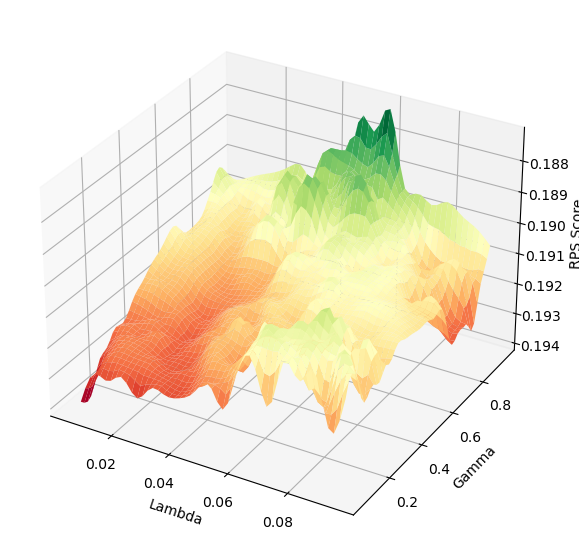

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_39518/3996774127.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap


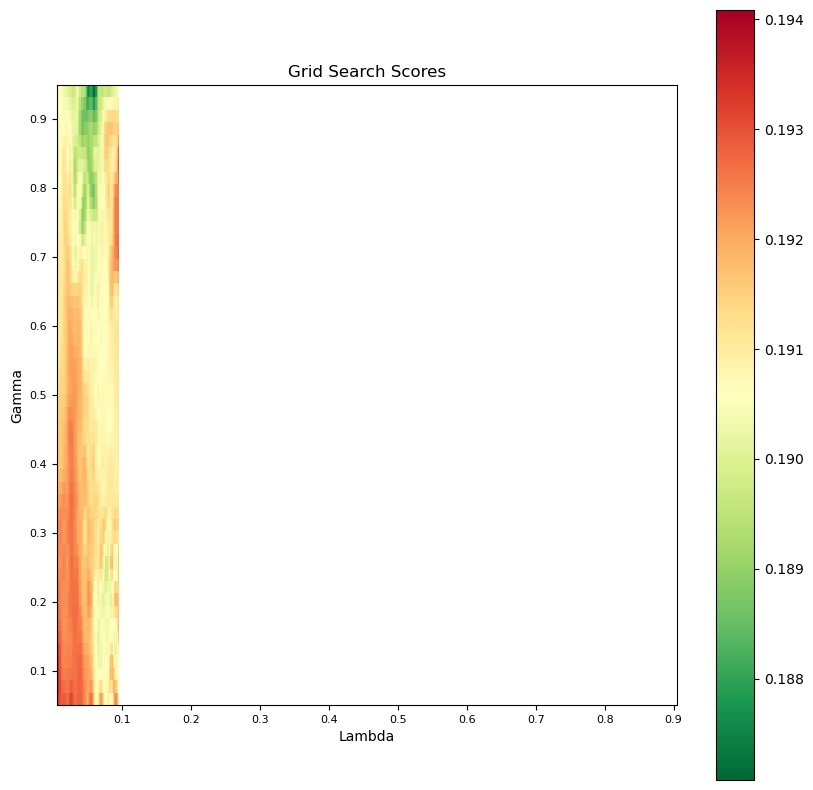

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_39518/3996774127.py:96: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')


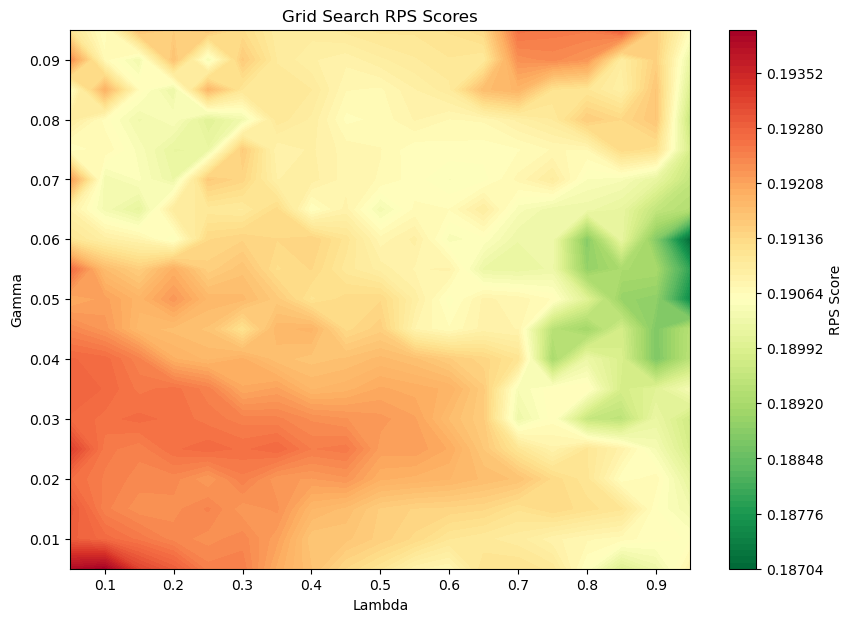

''

In [542]:

# Define a parameter grid with the ranges for your parameters
param_grid = {
    'learning_rate_lambda': np.arange(0.005, 0.1, 0.005),
    'learning_rate_gamma': np.arange(0.05, 1, 0.05)
}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable and best_params dictionary
best_score = float('inf')  # assuming lower scores are better; use -float('inf') if higher scores are better
best_params = {}

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    ratings = initialize_ratings(df_results, df_fixtures)

    # Update your learning rates
    learning_rate_lambda = params['learning_rate_lambda']
    learning_rate_gamma = params['learning_rate_gamma']

    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)

    df_train = pd.DataFrame(training_games)
    df_train.to_csv("../data/train.csv", index=False)
    model = train_model(df_train)

    all_rps, league_table = predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)
    score = np.mean(all_rps)  # Assuming score is calculated like this

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'learning_rate_lambda': learning_rate_lambda,
        'learning_rate_gamma': learning_rate_gamma,
        'score': score,
    })

print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame and plot them
df_gs_results = pd.DataFrame(gs_results)

# Define grid of x, y values
lambda_range = np.linspace(df_gs_results['learning_rate_lambda'].min(), df_gs_results['learning_rate_lambda'].max(), num=50)
gamma_range = np.linspace(df_gs_results['learning_rate_gamma'].min(), df_gs_results['learning_rate_gamma'].max(), num=50)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['learning_rate_lambda'], df_gs_results['learning_rate_gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_gs.png", dpi=300)
plt.show()

# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['learning_rate_lambda'].min(), param_grid['learning_rate_lambda'].max(), param_grid['learning_rate_gamma'].min(), param_grid['learning_rate_gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_gs.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs.png", dpi=300)
plt.show()

;